### Imports

In [1]:

import tensorflow as tf
print(tf.__version__)


2025-03-27 08:46:30.531434: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.2


In [2]:
# Standard Libraries
import os

# Data Handling
import numpy as np
import pandas as pd
from imblearn.over_sampling import ADASYN, SMOTE

# Machine Learning & Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
from sklearn.preprocessing import StandardScaler

# Hyperparameter Optimization
import optuna

# Model Saving & Experiment Tracking
import joblib
import mlflow
import mlflow.sklearn

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

/Users/adriandaschlein/Documents/uni/master/CBS/04_semester/master.nosync/master/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### MLFlow and Azure Tracking

If used with terminal (not Azure) use terminal command: mlflow ui --port 5000

In [3]:
TRACKING_URI = "azureml://northeurope.api.azureml.ms/mlflow/v1.0/subscriptions/716d3e14-e009-4f92-89c9-01fa8347272a/resourceGroups/adda23ac-rg/providers/Microsoft.MachineLearningServices/workspaces/fall"
mlflow.set_tracking_uri(TRACKING_URI)

### Load data

In [4]:
def load_data(file_name):
    '''
    Load data from a csv file into a pandas dataframe.
    
    Args:
    file_name: The name of the csv file to load
    
    Returns:
    df: A pandas dataframe containing the data from the csv file
    '''
    folder = "datasets"

    df = pd.read_csv(f"{folder}/{file_name}")
    return df

### Stratify Split

In [5]:
def stratified_activity_split(df, target_column="fall_binary", test_size=0.2, random_state=42):
    """
    Splits the dataset while ensuring 20% of each 'activity' is in the test set.

    Args:
        df (pd.DataFrame): The full dataset containing 'activity' and the target variable.
        target_column (str): The column representing the target labels.
        test_size (float): The fraction of each activity to be in the test set.
        random_state (int): Random seed for reproducibility.

    Returns:
        data_train (pd.DataFrame): Training set.
        data_test (pd.DataFrame): Test set.
    """

    train_list = []
    test_list = []

    #  Loop through each activity and apply train-test split
    for activity, group in df.groupby("activity"):
        train, test = train_test_split(group, test_size=test_size, random_state=random_state, stratify=group[target_column])
        train_list.append(train)
        test_list.append(test)

    #  Concatenate results into train & test datasets
    data_train = pd.concat(train_list).reset_index(drop=True)
    data_test = pd.concat(test_list).reset_index(drop=True)

    return data_train, data_test


### Evaluate Per Activity / Distance Functions

In [6]:
def evaluate_per_activity(model, test_X, test_y, feature_columns=None):
    """
    Evaluates model performance per activity type and logs the results in MLflow.

    Args:
        model: The trained model (LSTM or Tree-based).
        test_X: Test feature data (DataFrame).
        test_y: Test target labels (Series).
        target_column: The name of the target column.
        feature_columns: The feature columns used for training.

    Returns:
        A DataFrame containing classification results per activity.
    """
    
    #  Ensure X_test is a DataFrame
    if not isinstance(test_X, pd.DataFrame):
        test_X = pd.DataFrame(test_X, columns=feature_columns)

    # Convert test_y to Series if it's a NumPy array
    '''if isinstance(test_y, pd.DataFrame):
        test_y = test_y.squeeze()  # Convert to Series if needed'''
    if isinstance(test_y, np.ndarray):
        test_y = pd.Series(test_y.squeeze(), name="fall_binary")

    #  Ensure 'activity' column exists
    if "activity" not in test_X.columns:
        raise ValueError("Dataset does not contain an 'activity' column.")

    is_lstm = isinstance(model, tf.keras.Model)
    results = []

    #  Loop through each unique activity and evaluate model performance
    for activity in test_X["activity"].unique():
        # Filter test data for the current activity
        X_test_activity = test_X[test_X["activity"] == activity].copy()

        # Extract the actual labels
        y_test_activity = test_y.loc[X_test_activity.index].values.flatten()  # Ensure correct shape

        #  Check for missing values
        if np.isnan(y_test_activity).any():
            print(f"Warning: NaN values found in y_test_activity for activity {activity}!")
            y_test_activity = np.nan_to_num(y_test_activity, nan=0)  # Replace NaN with 0 (No Fall)

        #  Ensure y_test_activity is integer
        try:
            y_test_activity = y_test_activity.astype(int)
        except ValueError as e:
            print(f"Error converting y_test_activity to integer for activity {activity}: {e}")
            continue  # Skip this activity if conversion fails

        #  Select feature columns
        if is_lstm:
            feature_columns = [col for col in X_test_activity.columns if col.startswith("value")]

        X_test_activity = X_test_activity[feature_columns].values  # Extract feature values

        print(f"Activity: {activity}, X shape: {X_test_activity.shape}, y shape: {y_test_activity.shape}")

        #  Reshape X for LSTM input
        if is_lstm:
            X_test_activity = X_test_activity.reshape(-1, 500, 1)

        #  Predict fall_binary values
        y_pred = model.predict(X_test_activity).round().astype(int).flatten()

        #  Compute correct and incorrect counts
        correct = np.sum(y_pred == y_test_activity)
        incorrect = len(y_pred) - correct

        #  Determine if the first sample of the activity is a fall or not
        actual_fall = "Fall" if y_test_activity[0] == 1 else "No Fall"

        print(f"Activity {activity}: {correct} correct, {incorrect} incorrect")

        #  Store results
        results.append({
            "activity": activity,
            "Actual Fall": actual_fall,  #  Single column for actual fall status
            "correct": correct,
            "incorrect": incorrect,
            "total": len(y_pred),
            "accuracy": correct / len(y_pred) if len(y_pred) > 0 else 0
        })

    #  Convert results into a DataFrame
    results_df = pd.DataFrame(results)

    #  Mapping dictionary from abbreviations to full names
    activity_mapping = {
        "S": "Still",
        "CD": "Close Door",
        "KD": "Knock Door",
        "MA": "Minor Ambience (Sitting and Eating)",
        "FOB": "Fall of object (Backpack)",
        "FOL": "Fall of object (FaszienRolle)",
        "WBS": "Walk by Sensor",
        "RBS": "Rush by Sensor",
        "SC": "Sitting down on chair",
        "LC": "Laying down on couch",
        "STC": "Stand up from Chair",
        "PUF": "Picking something up from floor",
        "K": "Kneeling down then standing up",
        "SLB": "Standing Lost Balance",
        "TF": "Trip and Fall - Forwards",
        "SFB": "Slip and Fall - Backwards",
        "FCS": "Chair - Fall to side",
        "FCF": "Chair - Fall to Front",
        "LAF": "Lying - Awake Fall",
        "LSF": "Lying - Asleep Fall",
        "FR": "Fall Recovery",
        "KID": "Kids Running"
    }

    #  Function to extract the relevant part before the first '_'
    def get_activity_name(code):
        key = code.split('_')[0]  # Extract first part of activity code
        return activity_mapping.get(key, code)  # Replace with full name if exists

    #  Apply the mapping to the results dataframe
    results_df["activity"] = results_df["activity"].apply(get_activity_name)

    #  Save the results as a CSV file
    results_path = "activity_results.csv"
    results_df.to_csv(results_path, index=False)

    #  Log results in MLflow
    mlflow.log_artifact(results_path)

    print("\n📊 Per-Activity Results:")
    print(results_df)

    return results_df

In [ ]:
def evaluate_per_distance(model, test_X, test_y, feature_columns=None):
    """
    Evaluates model performance per distance type and logs the results in MLflow.

    Args:
        model: The trained model (LSTM or Tree-based).
        test_X: Test feature data (DataFrame).
        test_y: Test target labels (Series).
        feature_columns: The feature columns used for training.

    Returns:
        A DataFrame containing classification results per distance.
    """

    X_test = test_X.copy()
    y_test = test_y.copy()

    #  Ensure X_test is a DataFrame
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test, columns=feature_columns)

    '''#  Ensure y_test is a Series
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.squeeze()  # Convert to Series if needed'''
    #  Ensure y_test is a Series
    if isinstance(y_test, (np.ndarray, pd.Series)):
        test_y = pd.Series(y_test.squeeze(), name="fall_binary")  # Convert to Series

    is_lstm = isinstance(model, tf.keras.Model)

    #  Ensure 'distance_m' column exists
    if "distance_m" not in X_test.columns:
        raise ValueError("Dataset does not contain a 'distance_m' column.")

    #  Get unique distances and setup subplots dynamically
    unique_distances = sorted(X_test["distance_m"].unique())
    fig, axes = plt.subplots(len(unique_distances), 1, figsize=(6, 4 * len(unique_distances))) 

    results = []
    confusion_matrices = {}

    #  Loop through each unique distance and evaluate model performance
    for i, distance in enumerate(unique_distances):
        X_test_distance = X_test[X_test["distance_m"] == distance].copy()
        y_test_distance = y_test.loc[X_test_distance.index].values.flatten()  # Ensure correct shape

        #  Select feature columns
        if is_lstm:
            feature_columns = [col for col in X_test_distance.columns if col.startswith("value")]

        X_test_distance = X_test_distance[feature_columns].values  # Extract feature values

        print(f"Distance: {distance}, X shape: {X_test_distance.shape}, y shape: {y_test_distance.shape}")

        #  Reshape X for LSTM input
        if is_lstm:
            X_test_distance = X_test_distance.reshape(-1, 500, 1)

        #  Predict fall_binary values
        y_pred = model.predict(X_test_distance).round().astype(int).flatten()

        #  Compute correct and incorrect counts
        correct = np.sum(y_pred == y_test_distance)
        incorrect = len(y_pred) - correct

        #  Compute confusion matrix, ensuring both classes appear
        cm = confusion_matrix(y_test_distance, y_pred, labels=[1, 0])

        #  Ensure confusion matrix always has shape (2,2)
        if cm.shape == (1, 1):  
            cm_fixed = np.array([[cm[0, 0], 0], [0, 0]])  
        elif cm.shape == (1, 2):  
            cm_fixed = np.vstack([cm, [0, 0]])  
        elif cm.shape == (2, 1):  
            cm_fixed = np.hstack([cm, [[0], [0]]])  
        else:
            cm_fixed = cm  

        #  Correct confusion matrix order:
        # TP | FN
        # FP | TN
        cm_corrected = np.array([
            [cm_fixed[0, 0], cm_fixed[1, 0]],  # True Positives, False Negatives
            [cm_fixed[0, 1], cm_fixed[1, 1]]   # False Positives, True Negatives
        ])

        confusion_matrices[distance] = cm_corrected

        #  Plot confusion matrix with **correct** labels
        sns.heatmap(cm_corrected, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Actual Fall", "Actual No Fall"], 
                    yticklabels=["Predicted Fall", "Predicted No Fall"],
                    ax=axes[i] if len(unique_distances) > 1 else axes)
        axes[i].set_title(f"Confusion Matrix - Distance {distance}")
        axes[i].set_xlabel(" ")
        axes[i].set_ylabel(" ")

        print(f"Distance {distance}: {correct} correct, {incorrect} incorrect")

        #  Store results
        results.append({
            "distance": distance,
            "correct": correct,
            "incorrect": incorrect,
            "total": len(y_pred),
            "accuracy": correct / len(y_pred) if len(y_pred) > 0 else 0
        })

    #  Save and log confusion matrix plot
    confusion_matrix_path = "confusion_matrices_distance.png"
    plt.tight_layout()
    plt.savefig(confusion_matrix_path)
    plt.close()

    #  Convert results into a DataFrame
    results_df = pd.DataFrame(results)

    #  Save results as CSV
    results_path = "distance_results.csv"
    results_df.to_csv(results_path, index=False)

    #  Log results in MLflow
    mlflow.log_artifact(results_path)
    mlflow.log_artifact(confusion_matrix_path)

    print("\n📊 Per-Distance Results:")
    print(results_df)

    return results_df

### Train Classical Models

In [8]:
def objective(trial, model_class, X_train, y_train, augment_data=None):
    """
    Defines the Optuna optimization objective with K-Fold Cross-Validation.
    
    Args:
        trial: Optuna trial object.
        model_class: The model class (e.g., XGBClassifier, RandomForestClassifier, GradientBoostingClassifier, SVC).
        X_train, y_train: Training data (without separate test split).

    Returns:
        The average F1-score across all folds.
    """

    # Suggest hyperparameters based on model type
    if model_class == XGBClassifier:
        num_no_falls = sum(y_train == 0)
        num_falls = sum(y_train == 1)
        default_scale_pos_weight = num_no_falls / num_falls

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 10),
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", default_scale_pos_weight * 0.5, default_scale_pos_weight * 1.5)
        }
        model = XGBClassifier(**params, objective="binary:logistic", random_state=42)

    elif model_class == RandomForestClassifier:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        }
        model = RandomForestClassifier(**params, random_state=42)

    elif model_class == GradientBoostingClassifier:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        }
        model = GradientBoostingClassifier(**params, random_state=42)

    elif model_class == SVC:
        params = {
            "C": trial.suggest_float("C", 0.1, 100, log=True),
            "kernel": trial.suggest_categorical("kernel", ["linear", "rbf"]),
            "gamma": trial.suggest_float("gamma", 0.001, 10, log=True),
        }
        model = SVC(**params, probability=True, random_state=42)

    else:
        raise ValueError(f"Unsupported model class: {model_class.__name__}")

    # K-Fold Cross-Validation (Stratified to preserve class balance)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    ## Loop through each fold
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]  
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        #  Apply augmentation
        if augment_data == "ADASYN":
            adasyn = ADASYN()
            X_fold_train, y_fold_train = adasyn.fit_resample(X_fold_train, y_fold_train)

        elif augment_data == "SMOTE":
            smote = SMOTE()
            X_fold_train, y_fold_train = smote.fit_resample(X_fold_train, y_fold_train)

        ## Train and evaluate the model
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        f1_scores.append(f1_score(y_fold_val, y_pred))

    ## Return average F1-score across folds
    return np.mean(f1_scores)


In [9]:
def train_and_log_classical_model(
    model, 
    X_train, X_test, y_train, y_test, X_test_full,
    save_name="classification_model", 
    experiment_name="classical_models_experiment",
    target_column="fall_binary",
    feature_columns=None,
    if_optuna=True,
    n_trials=250,  # Number of hyperparameter tuning trials
    dataset_name="fall_data.csv",
    augment_data=None
):
    """
    Trains a classical ML model (RandomForest, XGBoost, GradientBoosting, or SVM) with optional hyperparameter tuning
    and logs everything to MLflow.

    Args:
        model: A classical ML model (RandomForest, XGBoost, GradientBoosting, or SVM).
        X_train, X_test, y_train, y_test: Pre-split training and testing datasets.
        save_name: Name to save the trained model.
        experiment_name: Name of the MLflow experiment.
        n_trials: Number of hyperparameter tuning trials.

    Returns:
        The trained model.
    """

    # Start MLflow experiment
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run():
        # Identify model class
        model_class = type(model)

        if if_optuna:
            #  Perform hyperparameter optimization
            study = optuna.create_study(direction="maximize")
            study.optimize(lambda trial: objective(trial, model_class, X_train, y_train, augment_data=augment_data), n_trials=n_trials)
        
            best_params = study.best_params
            print(f"Best Parameters: {best_params}")

            #  Train final model with best params
            if model_class == XGBClassifier:
                best_model = XGBClassifier(**best_params, objective="binary:logistic", use_label_encoder=False)
            elif model_class.__name__ == "GradientBoostingClassifier":
                best_model = model_class(**best_params, random_state=42)
            elif model_class.__name__ == "RandomForestClassifier":
                best_model = model_class(**best_params, random_state=42)
            elif model_class == SVC:
                best_model = SVC(**best_params, probability=True, random_state=42)  #  Enable probability for ROC AUC
            else:
                raise ValueError(f"Unsupported model class: {model_class.__name__}")
        else:
            best_model = model

        if augment_data == "ADASYN":
            # Count of Fall labels in training data
            num_falls = y_train.sum()
            num_no_falls = len(y_train) - num_falls

            adasyn = ADASYN()
            X_train, y_train = adasyn.fit_resample(X_train, y_train)

            # Count of Fall labels in augmented training data
            num_falls_augmented = y_train.sum()
            num_no_falls_augmented = len(y_train) - num_falls_augmented
            
            print(f"ADASYN: Original Fall count: {num_falls}, Augmented Fall count: {num_falls_augmented}")
            print(f"ADASYN: Original No Fall count: {num_no_falls}, Augmented No Fall count: {num_no_falls_augmented}")

            mlflow.log_param("ADASYN_Original_Falls", num_falls)
            mlflow.log_param("ADASYN_Augmented_Falls", num_falls_augmented)

        elif augment_data == "SMOTE":
            # Count of Fall labels in training data
            num_falls = y_train.sum()
            num_no_falls = len(y_train) - num_falls

            smote = SMOTE()
            X_train, y_train = smote.fit_resample(X_train, y_train)

            # Count of Fall labels in augmented training data
            num_falls_augmented = y_train.sum()
            num_no_falls_augmented = len(y_train) - num_falls_augmented

            print(f"SMOTE: Original Fall count: {num_falls}, Augmented Fall count: {num_falls_augmented}")
            print(f"SMOTE: Original No Fall count: {num_no_falls}, Augmented No Fall count: {num_no_falls_augmented}")

            mlflow.log_param("SMOTE_Original_Falls", num_falls)
            mlflow.log_param("SMOTE_Augmented_Falls", num_falls_augmented)

        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        # SVM needs probability predictions for AUC
        if hasattr(best_model, "predict_proba"):
            roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
        else:
            roc_auc = roc_auc_score(y_test, y_pred)

        #  Log model parameters
        mlflow.log_param("model_type", best_model.__class__.__name__)
        if if_optuna:
            for param, value in best_params.items():
                mlflow.log_param(param, value)
        mlflow.log_param("num_features", X_train.shape[1])

        # Log features used for training as list
        if feature_columns is not None:
            mlflow.log_param("features", feature_columns)
        
        # Log target column
        mlflow.log_param("target_column", target_column)
        
        mlflow.log_param("dataset", dataset_name)
            
        #  Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)

        #  Save best model
        models_folder = "models"
        if not os.path.exists(models_folder):
            os.makedirs(models_folder)
        save_path = os.path.join(models_folder, f"{save_name}.pkl")
        joblib.dump(best_model, save_path)
        mlflow.log_artifact(save_path)

        # Generate and save confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)

        conf_matrix = np.array([
            [conf_matrix[0, 0], conf_matrix[1, 0]],  # True Positives, False Positives
            [conf_matrix[0, 1], conf_matrix[1, 1]]   # False Negatives, True Negatives
        ])

        # Flip the order of labels for visualization
        plt.figure(figsize=(6, 4))
        sns.heatmap(
            conf_matrix[::-1, ::-1],  # Reverse rows and keep columns the same
            annot=True, fmt="d", cmap="Blues",
            xticklabels=["Actual Fall", "Actual No Fall"], 
            yticklabels=["Predicted Fall", "Predicted No Fall"],
        )
        plt.xlabel(" ")
        plt.ylabel(" ")
        plt.title("Confusion Matrix")
        conf_matrix_path = "confusion_matrix.png"
        plt.savefig(conf_matrix_path)
        plt.close()
        mlflow.log_artifact(conf_matrix_path)

        print(f"Model trained with accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")

        #  After training and evaluation, call the per-activity evaluation
        evaluate_per_activity(best_model, X_test_full, y_test, feature_columns)

        #  After training and evaluation, call the per-distance evaluation
        evaluate_per_distance(best_model, X_test_full, y_test, feature_columns)

    return best_model

### Pipelines

#### Graph plottings

In [25]:
def plot_loss(history, save_path=None):
    """
    Plots the training and validation loss curves.

    Args:
        history: The history object returned by model.fit().
        save_path: Optional path to save the plot as an image file.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path)
        print(f"Loss plot saved to {save_path}")
    else:
        plt.show()

In [43]:
def plot_accuracy(history, save_path=None):
    """
    Plots the training and validation accuracy curves.

    Args:
        history: The history object returned by model.fit().
        save_path: Optional path to save the plot as an image file.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path)
        print(f"Accuracy plot saved to {save_path}")
    else:
        plt.show()

#### Classical Model Pipeline

In [10]:
def train_pipe(
    model, 
    dataset_name, 
    save_name="fall_model", 
    feature_columns=None, 
    target_column="fall_binary", 
    experiment_name="default_experiment",
    use_early_stopping=True,
    if_optuna=True,
    n_trials=250,
    augment_data=None
):
    """
    General training pipeline for both classical models (XGBoost, RF, SVM) and deep learning models.

    Args:
        model: The initialized model (LSTM, RNN, RF, XGB, etc.).
        dataset_name: The dataset CSV file.
        save_name: Name to save the trained model.
        feature_columns: List of feature column names.
        target_column: The name of the target column.
        experiment_name: MLflow experiment name.
        use_early_stopping: Whether to use early stopping (for neural networks).
        if_optuna: Whether to perform hyperparameter tuning (for tree-based models).

    Returns:
        The trained model.
    """

    #  Prevent overwriting existing models unless explicitly handled
    if os.path.exists(f"models/{save_name}.pkl") or os.path.exists(f"models/{save_name}.keras"):
        raise ValueError(f"Model name '{save_name}' already exists. Choose a new name or delete the existing model.")

    #  Load dataset
    df = load_data(dataset_name)

    #  Auto-detect feature columns if not explicitly provided
    value_columns = [col for col in df.columns if col.startswith("value")]
    if value_columns:
        feature_columns = value_columns  
    elif feature_columns is None:
        raise ValueError("Feature columns must be specified.")

    #  Ensure target column exists
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset.")

    data_train, data_test = stratified_activity_split(df, target_column=target_column, test_size=0.2, random_state=42)
    print(f"Train shape: {data_train.shape}, Test shape: {data_test.shape}")

    #  Keep full test data (including metadata like 'activity' or 'distance_m')
    X_test_full = data_test.copy()  

    #  Keep `X_train`, `X_test` as DataFrames & `y_train`, `y_test` as Series
    X_train = data_train[feature_columns]  
    X_test = data_test[feature_columns]    
    y_train = data_train[target_column]  
    y_test = data_test[target_column]    

    #  Check model type
    is_tree = isinstance(model, (XGBClassifier, RandomForestClassifier, GradientBoostingClassifier))
    is_svm = isinstance(model, SVC)

    if is_svm:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        X_test_full[feature_columns] = scaler.transform(X_test_full[feature_columns])

        #  Convert X_train back to DataFrame
        X_train = pd.DataFrame(X_train, columns=feature_columns, index=data_train.index)
        X_test = pd.DataFrame(X_test, columns=feature_columns, index=data_test.index)
        X_test_full[feature_columns] = pd.DataFrame(X_test_full[feature_columns], columns=feature_columns, index=data_test.index)

    #  Train tree-based models with optional Optuna hyperparameter tuning
    if is_tree or is_svm:
        model = train_and_log_classical_model(
            model, X_train, X_test, y_train, y_test, X_test_full,
            save_name=save_name,
            experiment_name=experiment_name,
            target_column=target_column,
            feature_columns=feature_columns,
            if_optuna=if_optuna,
            n_trials=n_trials,
            dataset_name=dataset_name,
            augment_data=augment_data
        )
    
    # Delete the files activity_results.csv and distance_results.csv
    # Delete the files only if they exist
    files_to_remove = ["activity_results.csv", "distance_results.csv", "confusion_matrices_distance.png", "confusion_matrix.png"]
    for file in files_to_remove:
        if os.path.exists(file):
            os.remove(file)

    return model

#### NN Pipeline

In [62]:
import numpy as np
import mlflow.tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import json
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

def train_model(
    model, 
    dataset_name, 
    save_name="lstm_fall_model", 
    feature_columns=None, 
    target_column="fall_binary", 
    experiment_name="default_experiment",
    use_early_stopping=True,
    epochs=10,
    batch_size=32
):
    """
    Loads the dataset, reshapes it for RNN, trains the model, and logs everything to MLflow.
    """
    # Load dataset
    df = load_data(dataset_name)

    # Auto-detect value columns if not specified
    value_columns = [col for col in df.columns if col.startswith("value")]
    if value_columns:
        feature_columns = value_columns
    elif feature_columns is None:
        raise ValueError("Feature columns must be specified.")

    # Ensure target exists
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found.")

    # Stratified split using helper function
    data_train, data_test = stratified_activity_split(df, target_column=target_column)
    
    # Preserve test metadata
    X_test_full = data_test.copy()
    y_test_full = data_test[target_column].values

    # Extract features and labels
    X_train = data_train[feature_columns].values
    X_test = data_test[feature_columns].values
    y_train = data_train[target_column]
    y_test = data_test[target_column]

    # Reshape for RNN (samples, timesteps, features)
    # Account for 500 value columns (1 feature per timestep)
    X_train = X_train.reshape(-1, 500, 1)
    X_test = X_test.reshape(-1, 500, 1)

    print(f"Final reshaped shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

    # MLflow setup
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        # Log parameters
        mlflow.log_params({
            "epochs": epochs,
            "batch_size": batch_size,
            "input_shape": "500 timesteps, 1 feature",
            "optimizer": model.optimizer.get_config()["name"],
            "loss": model.loss,
            "dataset": dataset_name,
        })

        mlflow.log_text(str(model.summary()), "model_summary.txt")

        # Setup callbacks
        callbacks = []
        if use_early_stopping:
            early_stop = EarlyStopping(
                monitor="val_loss", 
                patience=3, 
                restore_best_weights=True
            )
            callbacks.append(early_stop)

        # compute class weights
        '''class_weights = compute_class_weight("balanced",
                                             classes=np.unique(y_train),
                                             y=y_train)
        class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
        print(f"Class weights: {class_weights_dict}")'''

        # --- SMOTE ---
        # Count of Fall labels in training data
        num_falls = y_train.sum()
        num_no_falls = len(y_train) - num_falls

        n_samples, timesteps, n_features = X_train.shape
        X_train_2d = X_train.reshape(n_samples, timesteps * n_features)

        smote = SMOTE()
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_2d, y_train)
        X_train_resampled = X_train_resampled.reshape(-1, timesteps, n_features)
        '''adasyn = ADASYN()
        X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_2d, y_train)
        X_train_resampled = X_train_resampled.reshape(-1, timesteps, n_features)'''
        mlflow.log_param("SMOTE", True)
        
        # Count of Fall labels in augmented training data
        num_falls_augmented = y_train_resampled.sum()
        num_no_falls_augmented = len(y_train_resampled) - num_falls_augmented

        print(f"SMOTE: Original Fall count: {num_falls}, Augmented Fall count: {num_falls_augmented}")
        print(f"SMOTE: Original No Fall count: {num_no_falls}, Augmented No Fall count: {num_no_falls_augmented}")

        mlflow.log_param("Original_Falls", num_falls)
        mlflow.log_param("Augmented_Falls", num_falls_augmented)

        # Update training data with resampled data
        X_train, y_train = X_train_resampled, y_train_resampled

        # Train model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
            # class_weight=class_weights_dict
        )

        # Evaluate
        results = model.evaluate(X_test, y_test, verbose=0)
        loss = results[0]
        accuracy = results[1]
        additional_metrics = results[2:]
        print("additional_metrics:", additional_metrics)
        
        # Log metrics
        mlflow.log_metrics({
            "final_accuracy": accuracy,
            "final_loss": loss,
            "final_val_accuracy": history.history["val_accuracy"][-1],
            "final_val_loss": history.history["val_loss"][-1]
        })

        plot_loss(history, save_path="loss_plot.png")
        plot_accuracy(history, save_path="accuracy_plot.png")
        mlflow.log_artifact("loss_plot.png")
        mlflow.log_artifact("accuracy_plot.png")
        os.remove("loss_plot.png")
        os.remove("accuracy_plot.png")

        # Per-activity and per-distance evaluation
        evaluate_per_activity(model, X_test_full, y_test_full, value_columns)
        evaluate_per_distance(model, X_test_full, y_test, value_columns)

        # Save model
        model.save(f"models/{save_name}.keras")
        mlflow.log_artifact(f"models/{save_name}.keras")

    return model

### Models

In [27]:
# ==========================
# XGBoost Model
# ==========================

def build_xgboost_model():
    """
    Builds an XGBoost model for binary classification.

    Returns:
        A compiled XGBoost model.
    """
    model = XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.11,
        objective="binary:logistic",
    )

    return model

# ==========================
# Random Forest======
# ===============================

def build_random_forest_model():
    """
    Builds a Random Forest model for binary classification.

    Returns:
        A compiled Random Forest model.
    """
    from sklearn.ensemble import RandomForestClassifier

    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        random_state=42
    )

    return model

# ==========================
# GBM Model
# ==========================
def build_gradient_boosting_model():
    """
    Builds a Gradient Boosting (GBM) model for binary classification.

    Returns:
        A compiled Gradient Boosting model.
    """
    return GradientBoostingClassifier(
        n_estimators=200,  # Number of boosting stages
        learning_rate=0.1,  # Step size shrinkage to prevent overfitting
        max_depth=5,  # Maximum depth of the trees
        random_state=42
    )

# ==========================
# SVM Model
# ==========================
from sklearn.svm import SVC

def build_svm_model():
    """
    Builds an SVM model for binary classification.

    Returns:
        A configured SVM model.
    """
    model = SVC(
        kernel="rbf",  # Radial Basis Function (RBF) kernel (default)
        C=1.0,         # Regularization parameter
        gamma="scale",  # Kernel coefficient
        probability=True,  # Enable probability estimates (needed for ROC AUC)
        random_state=42
    )
    return model


# ==========================
# RNN Model
# ==========================
def build_rnn_model():
    """
    Builds a simple RNN model using Keras.

    Returns:
        A compiled Keras model.
    """
    model = Sequential([
        SimpleRNN(RNN_UNITS, input_shape=INPUT_SHAPE, return_sequences=True),
        BatchNormalization(),  # Batch normalization
        SimpleRNN(RNN_UNITS),
        Dense(DENSE_UNITS, activation="relu"),
        Dropout(DROPOUT_RATE),
        Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=METRICS)
    return model

# ==========================
# LSTM Model
# ==========================
def build_lstm_model(l2_lambda=0.001, dropout_rate=0.2, clipnorm=1.0):
    """
    Builds an LSTM-based model with L2 regularization, dropout, and gradient clipping.

    Args:
        l2_lambda: Strength of L2 regularization (default: 0.001).
        dropout_rate: Dropout rate to reduce overfitting (default: 0.2).
        clipnorm: Gradient clipping norm (default: 1.0).

    Returns:
        A compiled Keras model.
    """
    model = Sequential([
        LSTM(RNN_UNITS, input_shape=INPUT_SHAPE, return_sequences=True, 
             kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),  # Batch normalization
        Dropout(dropout_rate),  # Dropout after first LSTM layer
        LSTM(RNN_UNITS, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),  # Dropout after second LSTM layer
        Dense(DENSE_UNITS, activation="relu", kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),  # Dropout before final layer
        Dense(1, activation="sigmoid")  # Output layer for binary classification
    ])
    
    optimizer = tf.keras.optimizers.Adam(clipnorm=clipnorm)
    model.compile(optimizer=optimizer, loss=LOSS_FUNCTION, metrics=METRICS)
    return model


# ==========================
# Bidirectional LSTM Model (Optional)
# ==========================
def build_bidirectional_lstm():
    """
    Builds a Bidirectional LSTM model for improved sequence learning.

    Returns:
        A compiled Keras model.
    """
    model = Sequential([
        Bidirectional(LSTM(RNN_UNITS, return_sequences=True, input_shape=INPUT_SHAPE)),
        Bidirectional(LSTM(RNN_UNITS)),
        Dense(DENSE_UNITS, activation="relu"),
        Dropout(DROPOUT_RATE),
        Dense(1, activation="sigmoid")
    ])
    
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=METRICS)
    return model


# ==========================
# CNN Model
# ==========================
def build_cnn_model():
    """
    Builds a Convolutional Neural Network (CNN) model for binary classification.

    Returns:
        A compiled Keras model.
    """
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=INPUT_SHAPE),
        MaxPooling1D(pool_size=2),
        Dropout(DROPOUT_RATE),
        Conv1D(filters=128, kernel_size=3, activation="relu"),
        MaxPooling1D(pool_size=2),
        Dropout(DROPOUT_RATE),
        Flatten(),
        Dense(DENSE_UNITS, activation="relu"),
        Dropout(DROPOUT_RATE),
        Dense(1, activation="sigmoid")
    ])
    
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=METRICS)
    return model


In [63]:
# ==========================
# CONFIGURABLE VARIABLES
# ==========================
RNN_UNITS = 256           # Number of RNN/LSTM units
DENSE_UNITS = 64         # Number of neurons in the dense layer
DROPOUT_RATE = 0.2      # Dropout rate for regularization
OPTIMIZER = "adam"       # Optimizer: "adam", "sgd", "rmsprop", etc.
LOSS_FUNCTION = "binary_crossentropy"  # "binary_crossentropy" for classification
METRICS = ["accuracy", "precision", "recall"]   # Metrics to monitor
EPOCHS = 20              # Number of training epochs
BATCH_SIZE = 64          # Batch size for training
INPUT_SHAPE = (500, 1)   # (Time steps, Features) - Adjust based on your dataset

### Training

In [64]:
model = build_cnn_model()  # Change this to your desired model
print(model.summary())  # Print model architecture
print(model)

/Users/adriandaschlein/Documents/uni/master/CBS/04_semester/master.nosync/master/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)              │ (None, 498, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 249, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 249, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 247, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 123, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 123, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 15744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │     1,007,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,032,705 (3.94 MB)

 Trainable params: 1,032,705 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

None
<Sequential name=sequential_11, built=True>


#### Training - Classical Models

In [51]:
# Train the model
trained_model = train_pipe(
    model=model,
    dataset_name="MPU_demean_features.csv",
    save_name="MPU_RNN_test",
    feature_columns=["median", "max", "mean", "p2p", "impulse"],
    target_column="fall_binary",
    experiment_name="NN Models MPU",
    use_early_stopping=False,
    if_optuna=True,
    n_trials=50,
    augment_data="SMOTE"
)

Train shape: (1016, 18), Test shape: (254, 18)


#### Training - Neural Networks

Final reshaped shapes:
X_train: (1016, 500, 1), y_train: (1016,)
X_test: (254, 500, 1), y_test: (254,)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)              │ (None, 498, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 249, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 249, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 247, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 123, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 123, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 15744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │     1,007,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,032,705 (3.94 MB)

 Trainable params: 1,032,705 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

SMOTE: Original Fall count: 328, Augmented Fall count: 688
SMOTE: Original No Fall count: 688, Augmented No Fall count: 688
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.6752 - loss: 0.5612 - precision: 0.6401 - recall: 0.7774 - val_accuracy: 0.9094 - val_loss: 0.2897 - val_precision: 0.8831 - val_recall: 0.8293
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8585 - loss: 0.3491 - precision: 0.8871 - recall: 0.8184 - val_accuracy: 0.9094 - val_loss: 0.2811 - val_precision: 0.9155 - val_recall: 0.7927
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.8666 - loss: 0.3343 - precision: 0.9249 - recall: 0.8072 - val_accuracy: 0.9213 - val_loss: 0.2760 - val_precision: 0.8974 - val_recall: 0.8537
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.8914 - loss: 0.3015 - precision: 0.9336 - recall: 0.8469 - val_accuracy: 0.9173 - val_loss: 0.2621 - val_precision: 0.8961 - val_recall: 0.8415
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2

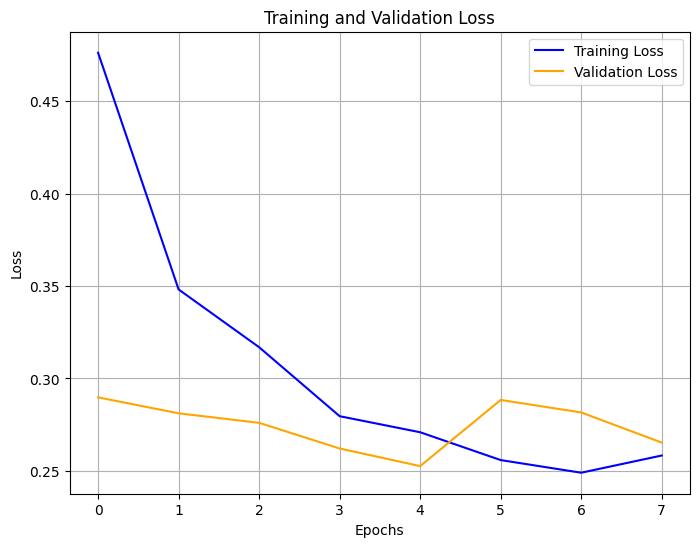

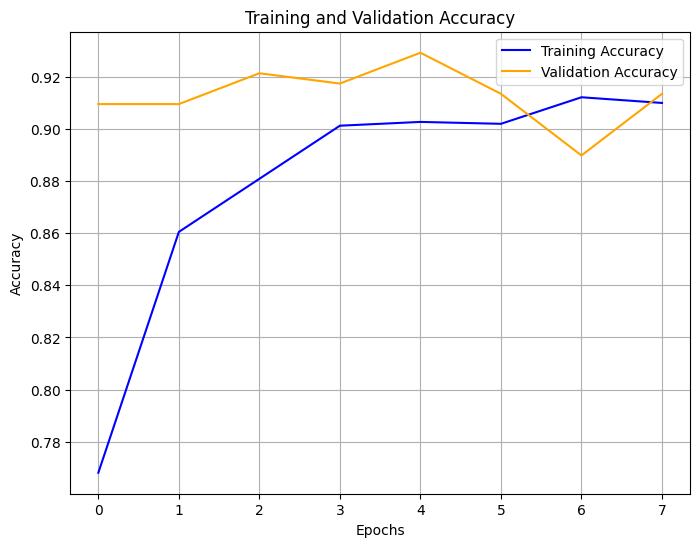

In [65]:
#  Use the correct training function for RNNs
trained_model = train_model(
    model=model,
    dataset_name="MPU_falls_demean.csv",
    # dataset_name="geophone.csv",
    save_name="GEO_CNN_1",
    experiment_name="NN Models MPU",
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    use_early_stopping=True
)

In [22]:
plot_loss(history, save_path="loss_plot.png")

NameError: name 'history' is not defined

### Feature Importance

In [25]:
def plot_feature_importance(model, feature_columns):
    """
    Plots feature importance for tree-based models.

    Args:
        model: Trained XGBoost, RandomForest, or GradientBoosting model.
        feature_columns: List of feature names.

    Returns:
        None (Displays feature importance plot)
    """
    if hasattr(model, "feature_importances_"):  # Ensure model supports feature importance
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({"Feature": feature_columns, "Importance": importances})
        feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(8, 6))
        sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:15])  # Top 15 features
        plt.title("Feature Importance")
        plt.show()

        return feature_importance_df
    else:
        raise ValueError("This model does not support feature importance.")

# Usage (after training a model)
plot_feature_importance(trained_model, ["median", "max", "mean", "p2p", "impulse"])


ValueError: This model does not support feature importance.

### Ensemble Predict

In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

def ensemble_predict(models_with_features, dataset_name, target_column):
    """
    Loads a dataset, splits it, loads an ensemble of models (with different feature sets),
    and predicts on the test set.

    Args:
        models_with_features: A list of tuples (model_path, feature_columns) specifying each model's file path
                              and the corresponding feature columns used for training.
        dataset_name: The name of the dataset CSV file.
        target_column: The name of the target column.

    Returns:
        None.
    """

    #  Load dataset
    df = load_data(dataset_name)

    #  Ensure target column exists
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset.")

    #  Train-test split
    data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)

    y_test = data_test[target_column].values  # Target remains the same for all models

    #  Load models and their feature columns
    models = []
    y_preds = []

    for model_path, feature_columns in models_with_features:
        model = joblib.load(model_path)  # Load model
        models.append(model)

        #  Extract the correct feature set for this model
        X_test = data_test[feature_columns].values  # Select only the features it was trained on

        #  Predict (check if the model has `predict_proba` for probability averaging)
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probability of the positive class
        else:
            y_pred_proba = model.predict(X_test)  # Some models might not have `predict_proba`

        y_preds.append(y_pred_proba)

    #  Ensemble predictions (Average probabilities and threshold at 0.5)
    y_pred = np.mean(y_preds, axis=0) > 0.5

    #  Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    #  Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    #  Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    #  Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Fall", "Fall"], yticklabels=["No Fall", "Fall"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 0.9764
Precision: 0.9615
Recall: 0.9615
F1 Score: 0.9615
ROC AUC: 0.9722


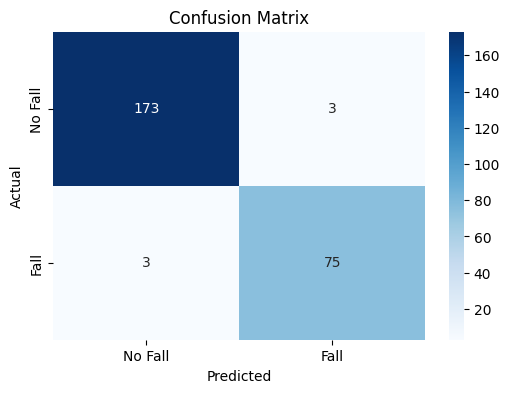

In [ ]:
ensemble_predict(
    models_with_features=[
        ("models/MF_XGB_Optuna.pkl", ["max", "min", "mean", "std", "median", "peak", "p2p", "energy", "rms", "crest", "shape", "impulse", "margin"]),  
        ("models/MF_XGB_RD40_Optuna.pkl", ["median", "max", "peak", "mean", "p2p"]),
        ("models/MF_XGB_RD41_Optuna.pkl", ["median", "max", "peak", "mean", "p2p"])    
    ],
    dataset_name="MPU_features_pca.csv",
    target_column="fall_binary"
)
